In [30]:
import os, sys

import torch
import scipy.stats as st
from scipy.spatial.distance import pdist, squareform
import numpy as np
import pandas as pd

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns

In [4]:
for p in ['../spotlight_ext']:
    module_path = os.path.abspath(os.path.join(p))
    if module_path not in sys.path:
        sys.path.append(module_path)

models_path = '../models'

In [5]:
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset

# get dataset
dataset = get_movielens_dataset(variant='1M')
train, test = random_train_test_split(dataset)

train = train.to_sequence()
test = test.to_sequence()

In [6]:
# load trained model
ofile = 'entire_model_1m.pt'
model = torch.load(os.path.join(models_path, ofile))

In [7]:
# initialize input parameters
k = 10
no_interactions = 10
total_CFs = 1
max_interacted_items_to_del = 4
user_id = 8

proximity_weight, diversity_weight = 1, 0

FLOAT_MAX = np.finfo(np.float32).max

## Compute losses

In [8]:
def compute_yloss(curr_score, kth_score):
    yloss = 0.0
    for i in range(total_CFs):
        temp_loss = curr_score/kth_score

        yloss += temp_loss    

    return yloss/total_CFs    

In [9]:
def compute_dist(x_hat, x1):
    """Compute weighted distance between two vectors."""
#     return sum(abs(x_hat - x1))
    diff = set(x1).difference(set(x_hat))
    return len(diff)

def compute_proximity_loss(cfs, x1):
    proximity_loss = 0.0
    for i in range(total_CFs):        
        proximity_loss += compute_dist(cfs[i], x1)
    return proximity_loss/total_CFs

In [10]:
def compute_diversity_loss():
    proximity_loss = 0.0
    return proximity_loss/total_CFs

In [11]:
def compute_loss():
    """Computes the overall loss"""
    yloss = compute_yloss()
    proximity_loss = compute_proximity_loss() if proximity_weight > 0 else 0.0
    diversity_loss = compute_diversity_loss() if diversity_weight > 0 else 0.0    

    loss = yloss + (proximity_weight * proximity_loss) - (diversity_weight * diversity_loss)
    return loss

In [69]:
class ItemInteractionInfo:
    user_id = -1
    item_id = -1
    score = 0
    pos = -1
    interactions = []
    complete_interactions = []
    recommends = []
    iter_no = -1
    satisfy_objective = True
    satisfy_contraints = True
    y_loss = FLOAT_MAX
    proximity_loss = FLOAT_MAX
    
    def __init__(self, uid, iid=-1, p=-1, i=None):
        self.user_id = uid
        self.item_id = iid
        self.pos = p
        self.interactions = i
        
    def __str__(self): 
        sorted_recommended_items = [(n[0], n[1].detach().numpy().flatten()[0]) if isinstance(n[1], torch.Tensor) else (n[0], n[1]) for n in self.recommends]
            
        return (f'\n'
                f'user_id: {self.user_id}, item_id: {self.item_id}\n'
                f'yloss: {round(self.y_loss, 4)}, proximity_loss: {int(self.proximity_loss)}\n'
                f'Item {self.item_id} is in position {self.pos} now!!!\n'
                f'Found in iteration {self.iter_no} and the interacted items are {self.interactions}\n'
                f'10-best recommended items {sorted_recommended_items}\n')
    
    def set_flags(self, do_objective, do_contraints):
        satisfy_objective = do_objective
        satisfy_contraints = do_contraints
    
    def needs_update(self, loss):
        is_better = [False, False]
        if len(loss):
            if self.satisfy_objective:
                if self.proximity_loss > loss['proximity']:
                    is_better[1] = True
            else: is_better[1] = True
            
            if self.satisfy_contraints:
                if loss['yloss'] < 1.0:
                    is_better[0] = True
            else: is_better[0] = True
                
            if all(is_better):
                return True
        
        return False    
    
    def set_values(self, predictions, interacted_items, tot_interacted_items, loss, iter_no, k=10):
        # get the ranking position of selected item in the list
        self.pos = st.rankdata(-predictions, method='ordinal')[self.item_id]
        self.recommends = sorted(enumerate(predictions), key=lambda x: x[1], reverse=True)[:k]
        self.iter_no = iter_no
        self.y_loss = loss[0]
        self.proximity_loss = loss[1]
        self.interactions = interacted_items
        self.complete_interactions = tot_interacted_items

In [241]:
items_interacted = test.sequences[test.user_ids==user_id][0]
predictions = -model.predict(items_interacted[:min(no_interactions, len(items_interacted))])
predictions[items_interacted] = FLOAT_MAX

print(f'Given the following interactions {items_interacted[:no_interactions]} for user {user_id}, the top-{k} recommended items are '
      f'{list(predictions.argsort()[:k])}')
cand_pos = input('Select item (position) to exclude from recommended list: ')
try:
    cand = predictions.argsort()[min(k, int(cand_pos)) - 1]
except ValueError:
    print("That's not an int!")

kth_item = predictions.argsort()[k - 1]

print(f'The selected item in pos {cand_pos} is {cand}\n')

Given the following interactions [446 508 447 488 472 514 437 493 512 444] for user 8, the top-10 recommended items are [482, 473, 582, 1439, 641, 686, 28, 1360, 1369, 499]


Select item (position) to exclude from recommended list:  7


The selected item in pos 7 is 28



In [329]:
from itertools import permutations, combinations
import torch.nn.functional as F


counter = 1
best_total_loss = ItemInteractionInfo(user_id, cand)
best_yloss = ItemInteractionInfo(user_id, cand)
best_yloss.satisfy_objective = False

for l in range(1, min(max_interacted_items_to_del, len(items_interacted)) + 1):
    print(f'Checking with {l} interacted items removed...')
#     produce permutations of various interactions
    perm = combinations(items_interacted[:min(no_interactions, len(items_interacted))], min(no_interactions, len(items_interacted)) - l)    

    for i in perm:
#         predict next top-k items about to be selected        
        preds = model.predict(i) 
#     convert logits produced by model, i.e., the probability distribution before normalization, by using softmax
        tensor = torch.from_numpy(preds).float()
        preds = F.softmax(tensor, dim=0)
        
        yloss = compute_yloss(preds.numpy()[cand], preds.numpy()[kth_item])
        proximity_loss = compute_proximity_loss(np.asarray(i)[np.newaxis, :], items_interacted)    
#     keep info about the best solution found depending on an objective function
        if best_total_loss.needs_update(dict(yloss=yloss, proximity=proximity_loss)):
            best_total_loss.set_values(preds, i, [yloss, proximity_loss], counter, k)
        if best_yloss.needs_update(dict(yloss=yloss, proximity=proximity_loss)):
            best_yloss.set_values(preds, i, [yloss, proximity_loss], counter, k) 

        counter += 1

similarity_rank = k - st.rankdata(similarity_matrix[cand, items_interacted]) + 1

print('\nBest total loss\n', '=' * len('Best total loss'), best_total_loss)
idx_items_exluded = np.where(np.isin(items_interacted, list(set(items_interacted).difference(set(best_total_loss.interactions)))))
print('Similarities of removed items: ', similarity_rank[idx_items_exluded])

print('\nBest yloss\n', '=' * len('Best yloss'), best_yloss)
idx_items_exluded = np.where(np.isin(items_interacted, list(set(items_interacted).difference(set(best_yloss.interactions)))))
print('Similarities of removed items: ', similarity_rank[idx_items_exluded])

print(f'\nTotal iterations: {counter}')

Checking with 1 interacted items removed...
Checking with 2 interacted items removed...
Checking with 3 interacted items removed...
Checking with 4 interacted items removed...

Best total loss
user_id: 8, item_id: 28
yloss: 0.9468, proximity_loss: 1
Item 28 is in position 12 now!!!
Found in iteration 3 and the interacted items are (446, 508, 447, 488, 472, 514, 437, 512, 444)
10-best recommended items [(482, 0.0068613114), (512, 0.0048286864), (1439, 0.0048122746), (473, 0.0047043166), (582, 0.004634982), (686, 0.0045875977), (905, 0.0036776608), (1369, 0.003592616), (485, 0.0034962047), (641, 0.0034026843)]
Similarities of removed items:  [9.]

Best yloss
user_id: 8, item_id: 28
yloss: 0.9855, proximity_loss: 4
Item 28 is in position 33 now!!!
Found in iteration 357 and the interacted items are (508, 514, 437, 493, 512, 444)
10-best recommended items [(686, 0.0072493297), (466, 0.0063285567), (1439, 0.006167974), (485, 0.006009351), (482, 0.005336869), (905, 0.0051946524), (483, 0.004

## Optimized technique using item-similarities

In [13]:
# compute the item-item similarity matrix

# construct 
M = np.zeros((dataset.num_users, dataset.num_items))
for u in range(1, dataset.num_users):    
    np.add.at(M[u], dataset.item_ids[dataset.user_ids==u], dataset.ratings[dataset.user_ids==u])

M_u = M.mean(axis=1)
item_mean_subtracted = M - M_u[:, np.newaxis]
similarity_matrix = 1 - squareform(pdist(item_mean_subtracted.T, 'cosine'))

In [70]:
from itertools import permutations, combinations
import torch.nn.functional as F


max_interacted_items_to_del = 4
k = 10
cand_pos = 7

best_tot_loss_data = []
best_yloss_data = []
users_no_data = []

print(f'Checking for user', end='')
delimiter = ''
for user_id in range(1, 20):  # dataset.num_users):
    print(f'{delimiter} {user_id}', end='')
    delimiter = ','
    
    best_total_loss = ItemInteractionInfo(user_id)
    best_yloss = ItemInteractionInfo(user_id)
    best_yloss.satisfy_objective = False
    
    try:
        if all(v > 0 for v in test.sequences[test.user_ids==user_id][0]):
            items_interacted = test.sequences[test.user_ids==user_id][0]
            predictions = -model.predict(items_interacted)
            predictions[items_interacted] = FLOAT_MAX
            kth_item = predictions.argsort()[k - 1]
            rec_item_exclude = predictions.argsort()[min(k, int(cand_pos)) - 1]
            
            best_total_loss.item_id = rec_item_exclude
            best_yloss.item_id = rec_item_exclude

            counter = 1        

            for l in range(1, min(max_interacted_items_to_del, len(items_interacted)) + 1):            
            #     produce permutations of various interactions
                perm = combinations(items_interacted, len(items_interacted) - l)    

                for i in perm:
            #         predict next top-k items about to be selected        
                    preds = model.predict(i) 
            #     convert logits produced by model, i.e., the probability distribution before normalization, by using softmax
                    tensor = torch.from_numpy(preds).float()
                    preds = F.softmax(tensor, dim=0)

                    yloss = compute_yloss(preds.numpy()[rec_item_exclude], preds.numpy()[kth_item])
                    proximity_loss = compute_proximity_loss(np.asarray(i)[np.newaxis, :], items_interacted)    
            #     keep info about the best solution found depending on an objective function
                    if best_total_loss.needs_update(dict(yloss=yloss, proximity=proximity_loss)):
                        best_total_loss.set_values(preds, i, items_interacted, [yloss, proximity_loss], counter, k)
                    if best_yloss.needs_update(dict(yloss=yloss, proximity=proximity_loss)):
                        best_yloss.set_values(preds, i, items_interacted, [yloss, proximity_loss], counter, k)                 

                    counter += 1
    except IndexError as err:        
        users_no_data.append(user_id)
        
    best_tot_loss_data.append(best_total_loss)
    best_yloss_data.append(best_yloss)

print('\nProcess ended')

Checking for user 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
Process ended


In [72]:
from collections import Counter


total_data = []
for rec in best_tot_loss_data:
    if rec.item_id == -1: continue
    
    similarity_rank = k - st.rankdata(similarity_matrix[rec.item_id, rec.complete_interactions]) + 1
    del_items_indices = np.where(np.isin(rec.complete_interactions, list(set(rec.complete_interactions).difference(set(rec.interactions)))))
    total_data.extend(list(similarity_rank[del_items_indices].astype(int)))
    
cnt = Counter(total_data)

(array([2., 1., 2., 1., 5., 4., 1., 4., 1., 1.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

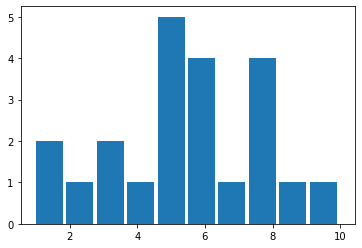

In [88]:
# with matplotlib
plt.hist(list(cnt.keys()), weights=list(cnt.values()), width=0.8)